# Monocular Depth Estimator

> Monocular Depth Estimator

In [ ]:
#| default_exp research

## Models

detectron2 - https://ai.meta.com/tools/detectron2/

## Datasets
nuscenes -

Imagenet - 

NYU Depth Dataset V2
Kitti
Sun rgb-d

## GLPN

The GLPN model was proposed in Global-Local Path Networks for Monocular Depth Estimation with Vertical CutDepth

In [ ]:
#|eval: false
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

In [ ]:
#|eval: false
feature_extractor = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-kitti")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti")

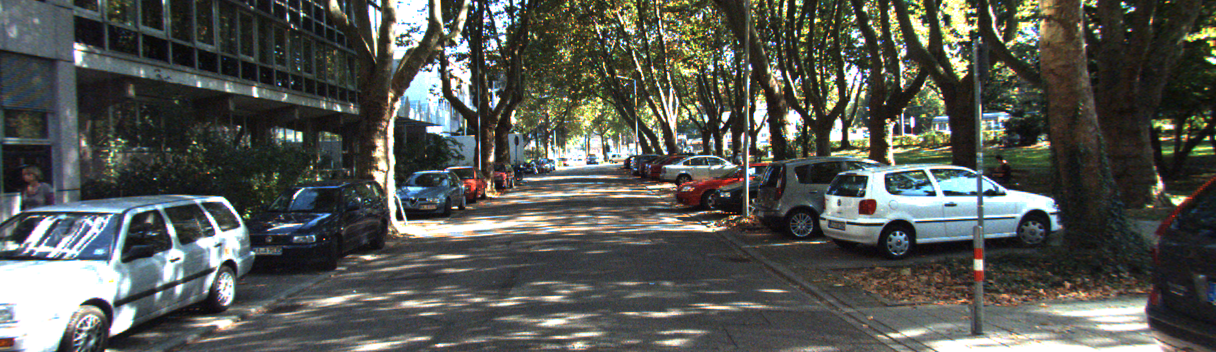

In [ ]:
#|eval: false
path = "./Data/data_depth_selection/depth_selection/test_depth_completion_anonymous/image/0000000000.png"

image = Image.open(path)
image

In [ ]:
#|eval: false
# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

In [ ]:
#|eval: false
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

In [ ]:
#|eval: false
# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

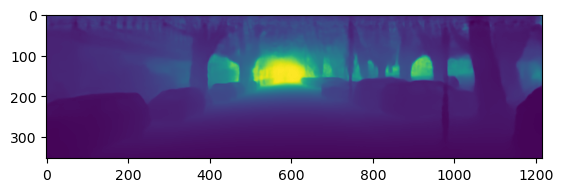

In [ ]:
#|eval: false
# visualize the prediction
output = prediction.squeeze().cpu().numpy()
plt.imshow(output)
plt.savefig("depth1png")

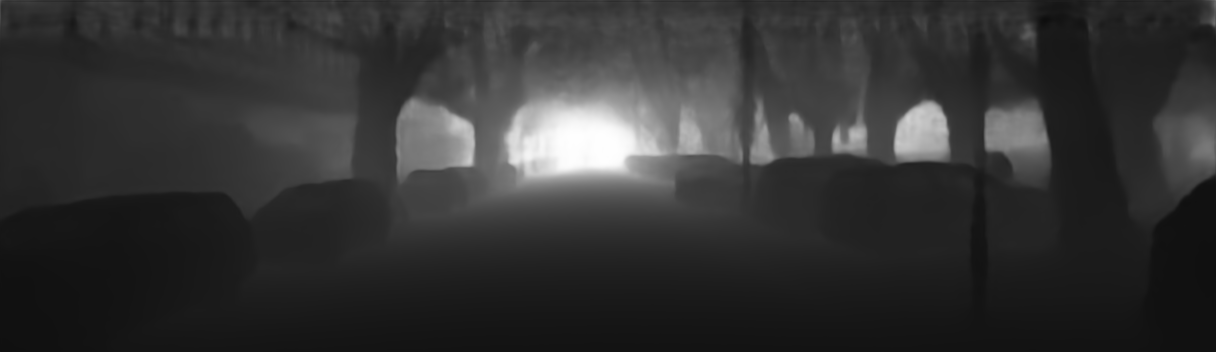

In [ ]:
#|eval: false
formatted = (output * 255 / np.max(output)).astype("uint8")
im = Image.fromarray(formatted)
im.show()  # show image
im.save('depth.jpg')  # save image

## Midas

In [ ]:
#|eval: false
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)


('dog.jpg', <http.client.HTTPMessage>)

In [ ]:
#|eval: false
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)


Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
#|eval: false
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
#|eval: false
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [ ]:
#|eval: false
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
#|eval: false
filename = path

In [ ]:
#|eval: false
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)


In [ ]:
#|eval: false
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output1 = prediction.cpu().numpy()

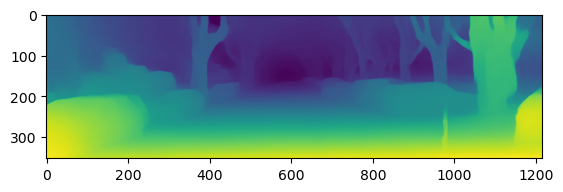

In [ ]:
#|eval: false
plt.imshow(output1)
plt.savefig("depth2.png")

# plt.show()